# Forecast Model Comparison 

Source DL models: https://pure.tudelft.nl/ws/portalfiles/portal/43646098/1_s2.0_S030626191830196X_main.pdf

## 1. Load Data

In [119]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Connect to the SQLite database (if the database doesn't exist, it will be created)
conn = sqlite3.connect('Main_DB')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Your SQL query
temp_df = '''
SELECT * from wind
'''

# Read SQL query result into a DataFrame
wind = pd.read_sql_query(temp_df, conn)
wind.rename(columns={'value': 'wind_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from spot_price
'''

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)
spot_price.rename(columns={'value': 'spot_price'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from solar
'''

# Read SQL query result into a DataFrame
solar = pd.read_sql_query(temp_df, conn)
solar.rename(columns={'value': 'solar_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from demand
'''

# Read SQL query result into a DataFrame
demand = pd.read_sql_query(temp_df, conn)
demand.rename(columns={'value': 'demand'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from nuclear
'''

# Read SQL query result into a DataFrame
nuclear = pd.read_sql_query(temp_df, conn)
nuclear.rename(columns={'value': 'nuclear_generation'}, inplace=True)

# SQL query
temp_df = '''
SELECT * from gas_data
'''

# Read SQL query result into a DataFrame
gas_data = pd.read_sql_query(temp_df, conn)
gas_data.rename(columns={'value': 'gas_price'}, inplace=True)
gas_data_hourly = gas_data.reindex(gas_data.index.repeat(24)).reset_index(drop=True)

# Close the connection
conn.close()

# Display the DataFrame


Create original df

In [97]:
df=wind.merge(spot_price, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(solar, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(demand, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(nuclear, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(gas_data, left_on=['day'], right_on=['delivery_day'])\
        .drop('delivery_day', axis=1)

df.head(5)

,wind_generation,day,hour,spot_price,solar_generation,demand,nuclear_generation,index_price
0,3214.0,2019-01-01,01:00,66.88,0.0,23753.0,6071.9,24.45
1,3222.0,2019-01-01,02:00,66.88,0.0,23018.0,6071.9,24.45
2,3081.0,2019-01-01,03:00,66.00,0.0,21808.0,6071.9,24.45
3,3069.0,2019-01-01,04:00,63.64,0.0,20635.0,6071.9,24.45
4,2973.0,2019-01-01,05:00,58.85,0.0,19824.0,6071.9,24.45


In [98]:
low_bidding_price = ['solar_generation', 'wind_generation', 'nuclear_generation']
renewable = ['solar_generation', 'wind_generation']

# Create a new column based on the condition
df['covered_renewables'] = (df[renewable].sum(axis=1) > df['demand']).astype(int)
df['covered_low_price'] = (df[low_bidding_price].sum(axis=1) > df['demand']).astype(int)

df = df.dropna()


In [101]:
X = df[['wind_generation', 'solar_generation', 'demand', 'index_price', 'nuclear_generation', 'covered_renewables', 'covered_low_price']]
y = df['spot_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


## 1. Linear Regression

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [106]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, pred_reg)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared
r2 = r2_score(y_test, pred_reg)
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 1369.261214422768
R-squared (R2): 0.7070227473274783


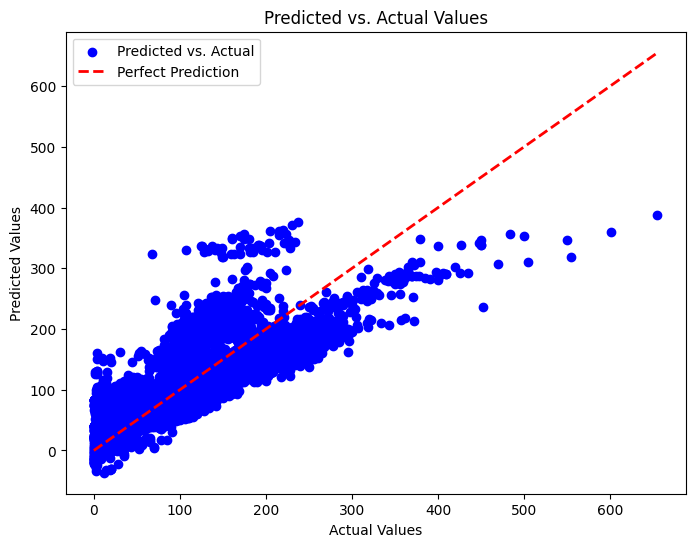

In [107]:
# Plotting the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_reg, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


In [120]:
df_comparison = pd.DataFrame({
    'Predicted': pred_reg,  
    'Actual': y_test        
})

## 2. CART

In [109]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

regressor = DecisionTreeRegressor(random_state=42, min_samples_split=50)
regressor.fit(X_train, y_train)

# Predict on the test set
pred_CART = regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(y_test, pred_CART)
print("Mean Squared Error:", mse)

Mean Squared Error: 422.94212714288386


In [110]:
df_comparison = pd.DataFrame({
    'Predicted': pred_CART,  
    'Actual': y_test        
})

,wind_generation,solar_generation,demand,index_price,nuclear_generation,covered_renewables,covered_low_price
5478,2067.0,77.6,22721.0,11.16,7117.2,0,0
5920,6016.0,3055.7,35061.0,10.84,7117.2,0,0
6868,8773.0,0.0,21179.0,12.16,6111.4,0,0
20026,11899.0,0.0,31227.0,19.66,6111.4,0,0
41600,4043.5,0.0,22383.8,36.03,7028.3,0,0
...,...,...,...,...,...,...,...
15837,1225.0,0.0,19971.0,14.01,6125.5,0,0
1029,2493.0,0.0,36417.0,20.81,7117.2,0,0
21990,10007.0,7472.0,24227.0,30.92,7117.2,0,1
33114,9180.0,8432.3,28078.5,82.35,6111.4,0,0


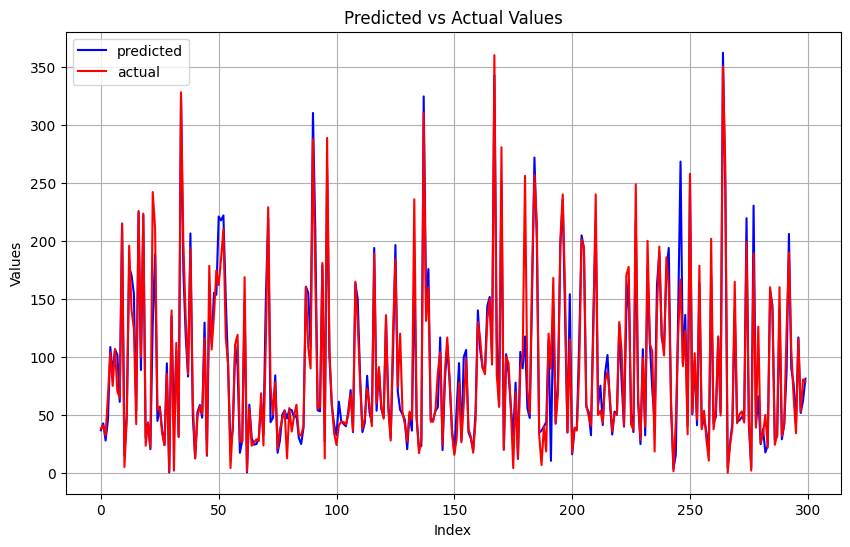

In [112]:
# Extracting 'Predicted' and 'Actual' columns from the DataFrame for the first 100 hours
predicted_values = df_comparison['Predicted'].iloc[:300]  # Selecting first 100 values
actual_values = df_comparison['Actual'].iloc[:300]  # Selecting first 100 values

# Creating a scatter plot for the first 100 hours
plt.figure(figsize=(10, 6))


# Connecting the dots with lines
plt.plot(range(len(predicted_values)), predicted_values, label='predicted', color='blue')  # Line connecting 'Predicted' values
plt.plot(range(len(actual_values)), actual_values, label='actual', color='red')  # Line connecting 'Actual' values

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


## 3. XGBOOST

In [121]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define XGBoost regressor
reg = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],  # Example values, adjust as needed
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)



Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


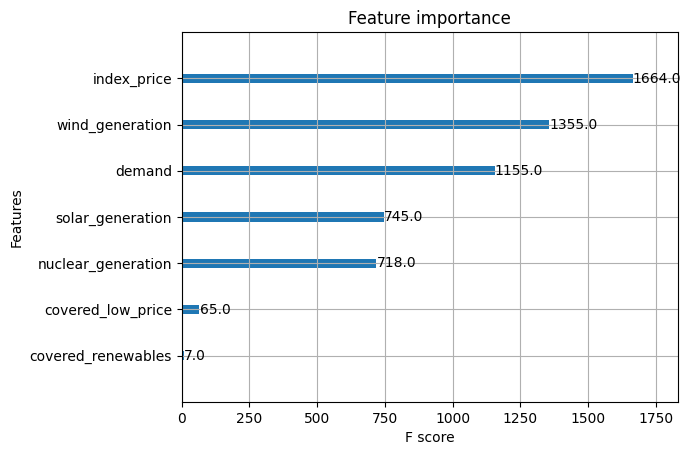

In [ ]:
# Assuming xgb_model is your trained XGBRegressor model
# Fit the model
xgb_optimal = reg.fit(X_train, y_train, verbose=False)

# Get feature importances from the booster
booster = xgb_optimal.get_booster()

# Plot feature importance
xgb.plot_importance(booster)
plt.show()


In [ ]:
df_comparison_xgb = pd.DataFrame({
    'Predicted': xgb_predict_optimal,  
    'Actual': y_test        
})


# Get the indices from df_comparison_xgb
indices = df_comparison_xgb.index.tolist()

# Retrieve the dates from 'df' based on the indices
dates = df.loc[indices, 'day']
hours = df.loc[indices, 'hour']

# Add the 'Date' column to df_comparison_xgb
df_comparison_xgb['day'] = dates.values
df_comparison_xgb['hour'] = hours.values

# Display the DataFrame with dates
print(df_comparison_xgb)



# Display the DataFrame
df_comparison_xgb

NameError: name 'xgb_predict_optimal' is not defined

In [ ]:
mse = mean_squared_error(y_test, xgb_predict_optimal)
mse

NameError: name 'xgb_predict_optimal' is not defined

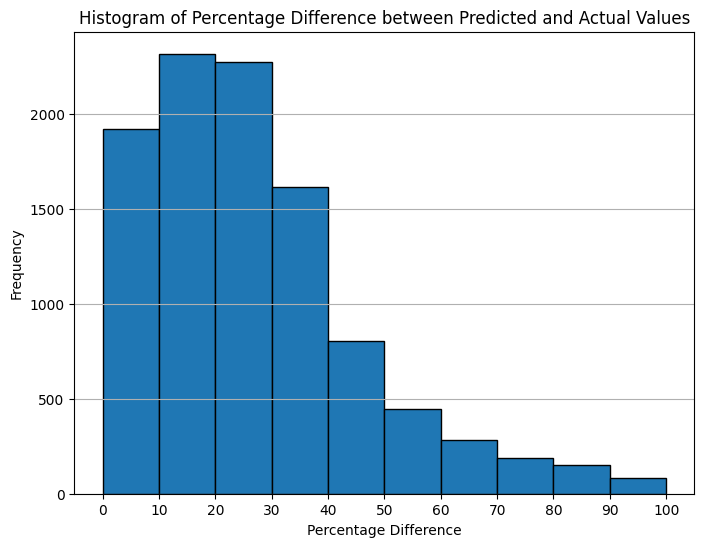

In [ ]:
# Calculate percentage difference between predicted and actual values
df_comparison_xgb['Absolute Difference (%)'] = (abs(df_comparison_xgb['Predicted'] - df_comparison_xgb['Actual']) / df_comparison_xgb['Actual']) * 100

# Define bins for the histogram (e.g., -10 to 10, 10 to 20, ..., 90 to 100)
bins = np.arange(0, 101, 10)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_comparison_xgb['Absolute Difference (%)'], bins=bins, edgecolor='black')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Difference between Predicted and Actual Values')
plt.xticks(bins)
plt.grid(axis='y')
plt.show()


In [ ]:
big_differences = df_comparison_xgb[df_comparison_xgb['Absolute Difference (%)']>50]

,Predicted,Actual,Absolute Difference (%)
35607,80.600207,5.05,1496.043696
43074,57.258355,23.44,144.276258
11879,52.999396,21.34,148.357055
12829,43.968634,23.80,84.742161
42670,41.199186,1.38,2885.448282
...,...,...,...
10863,56.981252,34.06,67.296687
35172,120.839137,45.00,168.531417
16284,49.659297,30.70,61.756667
12354,52.759315,21.10,150.044146


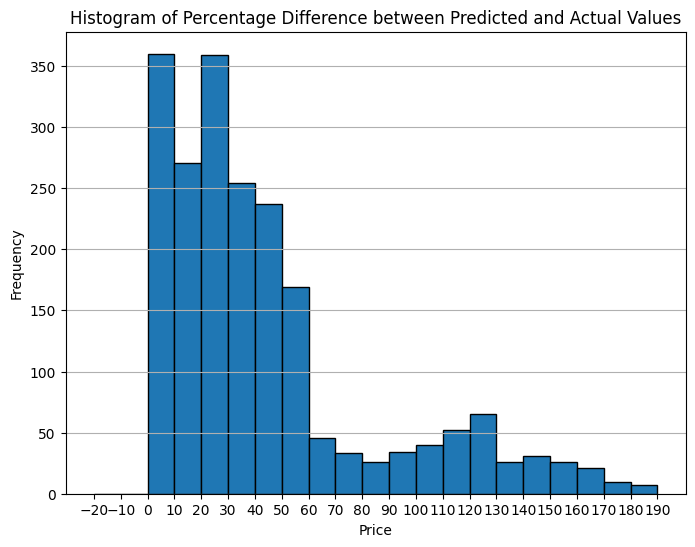

In [ ]:
# Define bins for the histogram (e.g., -10 to 10, 10 to 20, ..., 90 to 100)
bins = np.arange(-20, 200, 10)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(big_differences['Actual'], bins=bins, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Difference between Predicted and Actual Values')
plt.xticks(bins)
plt.grid(axis='y')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_comparison_xgb['Predicted'], df_comparison_xgb['Actual'])

26.414515932581036

In [ ]:
def categorize_price(price):
    if price == 0.0:
        return "0"
    if 0 <= price < 10:
        return "0-10"
    elif 10 <= price < 100:
        return f"{int(price // 10 * 10)}-{int(price // 10 * 10 + 10)}"
    else:
        return "+100"

# Assuming df_comparison_xgb is your DataFrame
df_comparison_xgb['Price Range'] = df_comparison_xgb['Actual'].apply(categorize_price)

# Group by 'Price Range' and calculate the mean of 'Absolute Difference (%)'
average_diff_by_range = df_comparison_xgb.groupby('Price Range')['Absolute Difference (%)'].mean()
df_comparison_xgb
#print(average_diff_by_range)


,Predicted,Actual,Absolute Difference (%),Price Range
5478,45.513468,38.01,19.740774,30-40
5920,56.896954,41.07,38.536534,40-50
6868,34.423974,32.07,7.340114,30-40
20026,62.794932,66.76,5.939287,60-70
41600,76.278600,104.04,26.683391,+100
...,...,...,...,...
15837,57.264175,40.40,41.743008,40-50
1029,95.549031,66.25,44.224953,60-70
21990,0.855235,18.77,95.443607,10-20
33114,129.012827,92.72,39.142393,90-100


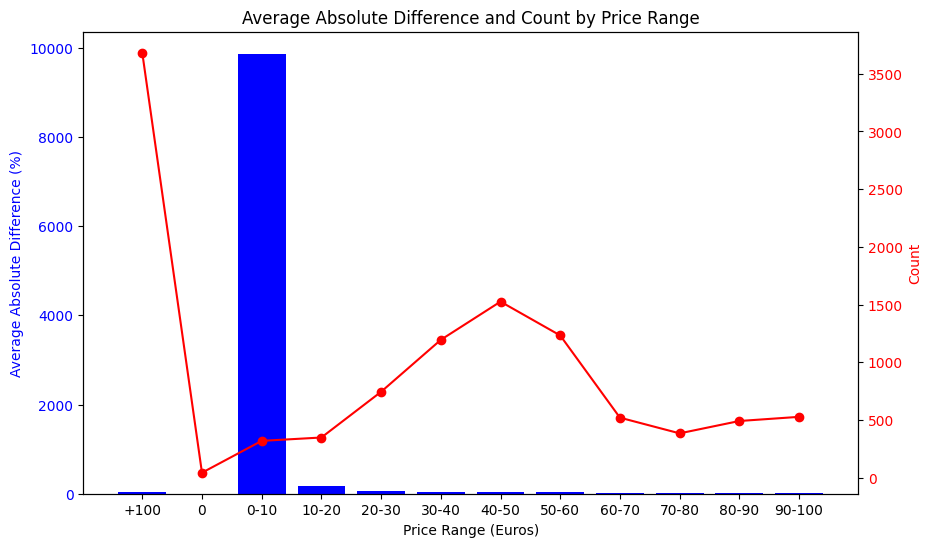

In [ ]:
import matplotlib.pyplot as plt

# Continuing from the previous code

# Group by 'Price Range' and calculate the mean of 'Absolute Difference (%)'
average_diff_by_range = df_comparison_xgb.groupby('Price Range')['Absolute Difference (%)'].mean().reset_index()

# Calculate the count for each price range
count_by_range = df_comparison_xgb['Price Range'].value_counts().reindex(average_diff_by_range['Price Range']).reset_index(drop=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for average absolute difference
ax1.bar(average_diff_by_range['Price Range'], average_diff_by_range['Absolute Difference (%)'], color='b')
ax1.set_xlabel('Price Range (Euros)')
ax1.set_ylabel('Average Absolute Difference (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adding the secondary axis for the count
ax2 = ax1.twinx()
ax2.plot(average_diff_by_range['Price Range'], count_by_range, color='r', marker='o')
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Titles and labels
plt.title('Average Absolute Difference and Count by Price Range')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

plt.show()


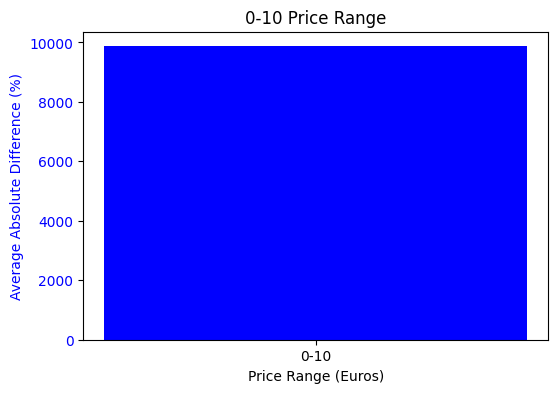

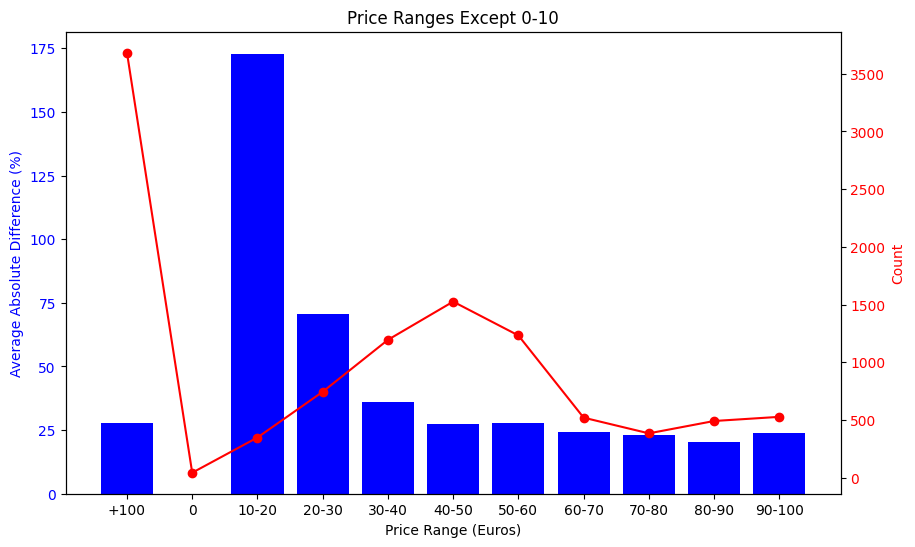

In [ ]:
import matplotlib.pyplot as plt

# Splitting the data
data_0_10 = average_diff_by_range[average_diff_by_range['Price Range'] == '0-10']
data_rest = average_diff_by_range[average_diff_by_range['Price Range'] != '0-10']

count_0_10 = count_by_range[average_diff_by_range['Price Range'] == '0-10']
count_rest = count_by_range[average_diff_by_range['Price Range'] != '0-10']

# Plot for 0-10 range
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(data_0_10['Price Range'], data_0_10['Absolute Difference (%)'], color='b')
ax1.set_xlabel('Price Range (Euros)')
ax1.set_ylabel('Average Absolute Difference (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('0-10 Price Range')
plt.show()

# Plot for the rest of the ranges
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(data_rest['Price Range'], data_rest['Absolute Difference (%)'], color='b')
ax1.set_xlabel('Price Range (Euros)')
ax1.set_ylabel('Average Absolute Difference (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Secondary axis for the count
ax2 = ax1.twinx()
ax2.plot(data_rest['Price Range'], count_rest, color='r', marker='o')
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Titles and labels
ax1.set_title('Price Ranges Except 0-10')
plt.xticks(rotation=45)
plt.show()


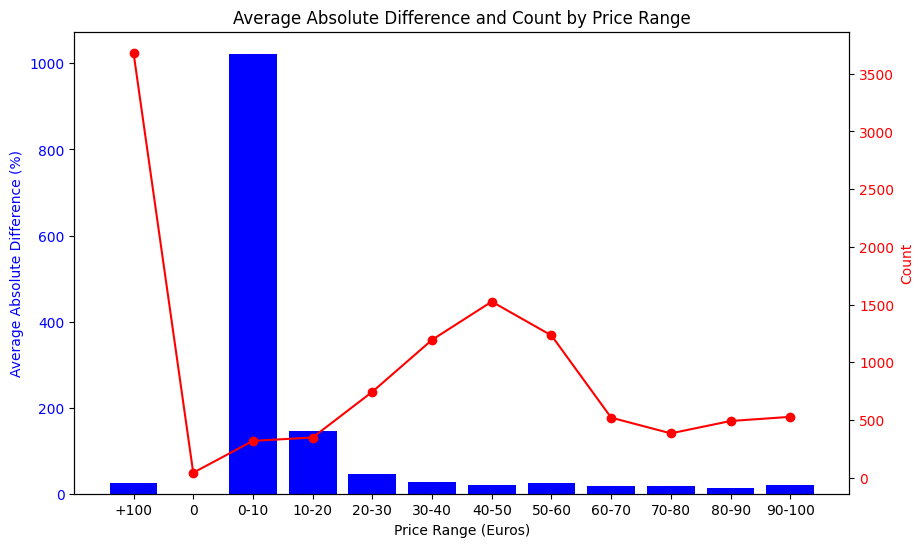

In [ ]:
import matplotlib.pyplot as plt

# Continuing from the previous code

# Group by 'Price Range' and calculate the mean of 'Absolute Difference (%)'
median_diff_by_range = df_comparison_xgb.groupby('Price Range')['Absolute Difference (%)'].median().reset_index()

# Calculate the count for each price range
count_by_range = df_comparison_xgb['Price Range'].value_counts().reindex(median_diff_by_range['Price Range']).reset_index(drop=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for average absolute difference
ax1.bar(median_diff_by_range['Price Range'], median_diff_by_range['Absolute Difference (%)'], color='b')
ax1.set_xlabel('Price Range (Euros)')
ax1.set_ylabel('Average Absolute Difference (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adding the secondary axis for the count
ax2 = ax1.twinx()
ax2.plot(median_diff_by_range['Price Range'], count_by_range, color='r', marker='o')
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Titles and labels
plt.title('Average Absolute Difference and Count by Price Range')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(df.shape[1]-3,)),  # input_shape should be the shape of your features
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # For regression, output_activation might be 'linear'. For binary classification, it could be 'sigmoid'. For multi-class classification, 'softmax'.
])


In [ ]:
model.compile(optimizer='adam', 
              loss='mean_absolute_error',  # e.g., 'mean_squared_error' for regression, 'binary_crossentropy' for binary classification
              metrics=['mean_absolute_error'])  # or other metrics like 'mae' for regression

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/100


1653/1653 [==============================] - 3s 1ms/step - loss: 63.4991 - mean_absolute_error: 63.4991 - val_loss: 48.1913 - val_mean_absolute_error: 48.1913
Epoch 2/100
1653/1653 [==============================] - 2s 1ms/step - loss: 48.7418 - mean_absolute_error: 48.7418 - val_loss: 42.1361 - val_mean_absolute_error: 42.1361
Epoch 3/100
1653/1653 [==============================] - 2s 1ms/step - loss: 36.2946 - mean_absolute_error: 36.2946 - val_loss: 24.6475 - val_mean_absolute_error: 24.6475
Epoch 4/100
1653/1653 [==============================] - 2s 1ms/step - loss: 24.7875 - mean_absolute_error: 24.7875 - val_loss: 24.6010 - val_mean_absolute_error: 24.6010
Epoch 5/100
1653/1653 [==============================] - 2s 1ms/step - loss: 21.9231 - mean_absolute_error: 21.9231 - val_loss: 17.0228 - val_mean_absolute_error: 17.0228
Epoch 6/100
1653/1653 [==============================] - 2s 1ms/step - loss: 21.3765 - mean_absolute_error: 21.3765 - val_loss: 22.7147 - val_m

In [ ]:
model.evaluate(X_test, y_test)


345/345 [==============================] - 0s 770us/step - loss: 19.3124 - mean_absolute_error: 19.3124


[19.31236457824707, 19.31236457824707]

In [ ]:
predictions = model.predict(X_test)  # X_new is the new data for which you want predictions


345/345 [==============================] - 0s 711us/step


In [ ]:
predictions = predictions.ravel()

test_dnn = pd.DataFrame({'pred':predictions,
                   'actual':y_test})
test_dnn

,pred,actual
5478,33.672497,38.01
5920,40.482807,41.07
6868,29.236256,32.07
20026,46.776680,66.76
41600,91.528954,104.04
...,...,...
15837,35.847000,40.40
1029,56.922218,66.25
21990,18.990427,18.77
33114,127.042229,92.72
